# E04 네이버 영화리뷰 감성분석 도전하기


## ◈ 학습목표
1. 텍스트 데이터를 머신러닝 입출력용 수치데이터로 변환하는 과정을 이해한다.  
2. RNN의 특징을 이해하고 시퀀셜한 데이터를 다루는 방법을 이해한다.  
3. 1-D CNN으로도 텍스트를 처리할 수 있음을 이해한다.  
4. IMDB와 네이버 영화리뷰 데이터셋을 이용한 영화리뷰 감성분류 실습을 진행한다.  

* 한국어 텍스트의 감정분석을 진행
* 활용할 데이터셋은 네이버 영화의 댓글을 모아 구성된 `Naver sentiment movie corpus`

` wget https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt 
 wget https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt 
 mv ratings_*.txt ~/aiffel/sentiment_classification`  
 
## **Step 순서  **  
1. 데이터 준비와 확인  
2. 데이터 로더 구성  
3. 모델구성을 위한 데이터 분석 및 가공  
4. 모델구성 및 validation set 구성  
5. 모델 훈련  
6. Loss, Accuracy 그래프 시각화  
7. 학습된 Embedding 레이어 분석  
8. 한국어 Word2Vec 임베딩 활용하여 성능개선  


## Step1. 데이터 준비와 확인

In [1]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter

# Naver sentiment movie corpus 읽기
train_data = pd.read_table('~/aiffel/sentiment_classification/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/ratings_test.txt')

#num, id와 document label(1긍정, 0부정)
train_data.head(10)

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1
5,5403919,막 걸음마 뗀 3세부터 초등학교 1학년생인 8살용영화.ㅋㅋㅋ...별반개도 아까움.,0
6,7797314,원작의 긴장감을 제대로 살려내지못했다.,0
7,9443947,별 반개도 아깝다 욕나온다 이응경 길용우 연기생활이몇년인지..정말 발로해도 그것보단...,0
8,7156791,액션이 없는데도 재미 있는 몇안되는 영화,1
9,5912145,왜케 평점이 낮은건데? 꽤 볼만한데.. 헐리우드식 화려함에만 너무 길들여져 있나?,1


## Step2. 데이터 로더 구성
실습때 다루었던 `IMDB 데이터셋`은 텍스트를 가공하여 `imdb.data_loader() 메소드를 호출`하면 `숫자 인덱스로 변환된 텍스트`와 `word_to_index 딕셔너리`까지 친절하게 제공합니다.  
그러나 이번에 다루게 될 `nsmc 데이터셋`은 `전혀 가공되지 않은 텍스트 파일`로 이루어져 있습니다.  
이것을 읽어서 `imdb.data_loader()와 동일하게 동작`하는 자신만의 data_loader를 만들어 보는 것으로 시작합니다. 

`data_loader 안에서 다음을 수행`
* **데이터의 중복 제거**  
* **NaN 결측치 제거**  
* **한국어 토크나이저로 토큰화**  
* **불용어(Stopwords) 제거**      **`3가지 stopwords로 모두 해봄`**  
* **사전 word_to_index 구성**  
* **텍스트 스트링을 dictionary 인덱스 스트링으로 변환**  
* **X_train, y_train, X_test, y_test, word_to_index 리턴**

In [2]:
from konlpy.tag import Mecab
tokenizer = Mecab()

## Stopwords를 다양하게 시도해 봄 결과값이 크게 차이 나지 않음
#==================================================================#
# 1. 18개
stopwords1 = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']
import os
fname = os.getenv('HOME')+'/korean_stopwords.txt'

#2. 675개 (https://www.ranks.nl/stopwords/korean에서 한굴 불용어(Stopwords)를 다운 받아서 리스트로 만들어서 사용)
stopwords2 = [line.rstrip('\n') for line in open(fname, 'r')]

#3. 101개 (한국어 불용어 리스트) : https://bab2min.tistory.com/544 
fname2 = os.getenv('HOME')+'/korean_stopwords(100).txt'
stopwords3 = [line.rstrip('\n') for line in open(fname2, 'r')]

#3가지 방법 중에 선택하여 Stopwords 제거하기 
stopwords = stopwords1
#stopwords = stopwords2
#stopwords = stopwords3

print(len(stopwords))
print(stopwords)
#==================================================================#

18
['의', '가', '이', '은', '들', '는', '좀', '잘', '걍', '과', '도', '를', '으로', '자', '에', '와', '한', '하다']


In [3]:
#print(len(stopwords))

#함수 load_data==============================================#
def load_data(train_data, test_data, num_words = 10000):
    
    ###pandas의 drop_duplicates 함수 사용하여 중복 제거###
    train_data.drop_duplicates(subset=['document'], inplace=True)   
    ###pandas의 dropna 함수 사용하여 NaN결측치 제거###  axis = 0(row)  1(column) any(하나라도 있음 제거)..
    train_data = train_data.dropna(how='any')
        
    ##test_data의 중복 제거
    test_data.drop_duplicates(subset=['document'], inplace = True)
    ##test_data의 NaN결측치 제거
    test_data = test_data.dropna(how='any')
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        #조사등의 불용어(Stopwords) 제거
        temp_X = [word for word in temp_X if not word in stopwords]  
        X_train.append(temp_X)
    
    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords]
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]   #지정된 4개 단어 빼고 word_to_index 만들기
    word_to_index = {word : index for index, word in enumerate(vocab)}
    
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
    
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
    
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index 

#함수 load_data   word_to_index 리턴 ===========================================#

#함수 실행 load_data
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [4]:
#word_to_index에서 index_to_word로 바꾸기 (dictionary)
index_to_word = {index : word for word, index in word_to_index.items()}

In [5]:
#문장 1개를 활용할 dictionary와 함께 주면,
#단어 인덱스 리스트 벡터로 변환 함수 
# 모든 문장은 <BOS>로 시작 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]


## Step3. 데이터 분석 및 가공

In [6]:
total_data_text = list(X_train) + list(X_test)

#텍스트 데이터 문장길이의 리스트를 생성
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

#문장 길이의 평균값, 최대값, 표준편차를 계산
print("문장 길이의 평균 : ", np.mean(num_tokens))
print("문장 길이의 최대 : ", np.max(num_tokens))
print("문장 길이 표준 편차 : ", np.std(num_tokens))

#최대 길이 (평균 + 4*표준편차) 너무 길면 시간이 오래 걸린다. 
max_tokens = np.mean(num_tokens) +4*np.std(num_tokens)
maxlen = int(max_tokens)
print("pad_sequences maxlen : ", maxlen)
print("전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다.".format(np.sum(num_tokens<max_tokens)/len(num_tokens)))

문장 길이의 평균 :  15.969355837799927
문장 길이의 최대 :  116
문장 길이 표준 편차 :  12.843536204665021
pad_sequences maxlen :  67
전체 문장의 0.99755809131817%가 maxlen 설정값 이내에 포함됩니다.


/home/aiffel-dj56/anaconda3/envs/aiffel/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


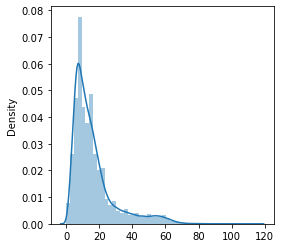

In [7]:
#문장 길이 분포 확인
plt.rcParams['figure.figsize'] = (4, 4)
plt.rcParams['grid.color'] = '#F0F0F0'
plt.rcParams['grid.linestyle'] = 'solid'
sns.distplot(num_tokens)
plt.style.use("bmh")
plt.show()

In [8]:
#길이 맞추는 padding은 post와 pre 중 앞쪽에 맞추는 pre로 함
#마지막에 입력되는 값이 크게 value에 작용하기 때문에 앞쪽을 비우고(pre) 뒤쪽에 의미값이 있는 것이 좋음
x_train = keras.preprocessing.sequence.pad_sequences(X_train,
                            value = word_to_index['<PAD>'],
                            padding = 'pre', maxlen = maxlen)
x_test = keras.preprocessing.sequence.pad_sequences(X_test,
                            value = word_to_index['<PAD>'],
                            padding = 'pre', maxlen = maxlen)
print(x_train.shape)

(146182, 67)


In [9]:
print(get_decoded_sentence(x_train[0], index_to_word))
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨

<PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 아 더 빙 . . 진짜 짜증 나 네요 목소리
라벨:  0


## Step4. 모델구성 및 validation set 구성
1. LSTM(RNN)    
2. Conv(CNN)  
3. Maxpooling  

In [10]:
#validation set 구성
#10000건 분리 - train data
x_val = x_train[:10000]
y_val = y_train[:10000]

# validation set을 제외한 나머지 - validation data
partial_x_train = x_train[10000:]
partial_y_train = y_train[10000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(136182, 67)
(136182,)


In [11]:
vocab_size = 10000 # 어휘 사전의 크기
word_vector_dim = 15 # 워드 벡터의 차원수   15->200으로 변경하면 loss값이 오히려 좋지 않은 결과을 얻음 

In [12]:
#model 설계
#1.LSTM(RNN)
model1 = keras.Sequential()
model1.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model1.add(keras.layers.LSTM(word_vector_dim))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용 LSTM state 벡터의 차원수는 8(변경가능)
model1.add(keras.layers.Dense(8, activation='relu'))
model1.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim

model1.summary()

#2.Conv(CNN)
model2 = keras.Sequential()
model2.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model2.add(keras.layers.Conv1D(16, 7, activation='relu'))
model2.add(keras.layers.MaxPooling1D(5))
model2.add(keras.layers.Conv1D(16, 7, activation='relu'))
model2.add(keras.layers.GlobalMaxPooling1D())
model2.add(keras.layers.Dense(8, activation='relu'))
model2.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim.

model2.summary()

#3.GlobalMaxPooling
model3 = keras.Sequential()
model3.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model3.add(keras.layers.GlobalMaxPooling1D())
model3.add(keras.layers.Dense(8, activation='relu'))
model3.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim

model3.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 15)          150000    
_________________________________________________________________
lstm (LSTM)                  (None, 15)                1860      
_________________________________________________________________
dense (Dense)                (None, 8)                 128       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 151,997
Trainable params: 151,997
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 15)          150000    
____________________________

## Step5 모델 훈련 ♣ Model 1 - LSTM(RNN) 

In [13]:
model1.compile(optimizer = 'adam',
             loss = 'binary_crossentropy', 
             metrics=['accuracy'])

epochs = 10    #20->10 일찍 수렴하여 줄임

history = model1.fit(partial_x_train, partial_y_train,
                   epochs = epochs, batch_size = 512,
                   validation_data = (x_val, y_val),
                   verbose = 1)

Epoch 1/10
266/266 [==============================] - 2s 7ms/step - loss: 0.4824 - accuracy: 0.7745 - val_loss: 0.3507 - val_accuracy: 0.8471
Epoch 2/10
266/266 [==============================] - 2s 6ms/step - loss: 0.3373 - accuracy: 0.8566 - val_loss: 0.3410 - val_accuracy: 0.8535
Epoch 3/10
266/266 [==============================] - 2s 6ms/step - loss: 0.3182 - accuracy: 0.8661 - val_loss: 0.3434 - val_accuracy: 0.8522
Epoch 4/10
266/266 [==============================] - 2s 6ms/step - loss: 0.3049 - accuracy: 0.8726 - val_loss: 0.3409 - val_accuracy: 0.8528
Epoch 5/10
266/266 [==============================] - 2s 6ms/step - loss: 0.2946 - accuracy: 0.8776 - val_loss: 0.3423 - val_accuracy: 0.8531
Epoch 6/10
266/266 [==============================] - 2s 6ms/step - loss: 0.2828 - accuracy: 0.8838 - val_loss: 0.3411 - val_accuracy: 0.8548
Epoch 7/10
266/266 [==============================] - 2s 6ms/step - loss: 0.2731 - accuracy: 0.8888 - val_loss: 0.3449 - val_accuracy: 0.8537
Epoch 

## Step6 Loss, Accuracy 그래프 시각화 ♣ Model 1 - LSTM(RNN) 

In [14]:
results = model1.evaluate(x_test, y_test, verbose = 2)
print(results)

1537/1537 - 2s - loss: 0.3618 - accuracy: 0.8471
[0.36182692646980286, 0.8471428155899048]


In [15]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


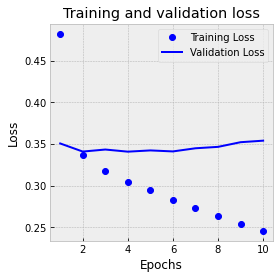

In [16]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label = "Training Loss")
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title("Training and validation loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

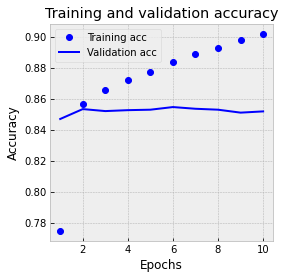

In [17]:
plt.clf() # 그림 초기화

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title("Training and validation accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## Step5 모델 훈련 ♣ Model 2 - Conv(CNN)

In [18]:
model2.compile(optimizer = 'adam',
             loss = 'binary_crossentropy', 
             metrics=['accuracy'])

epochs = 10    #20->10 일찍 수렴하여 줄임

history = model2.fit(partial_x_train, partial_y_train,
                   epochs = epochs, batch_size = 512,
                   validation_data = (x_val, y_val),
                   verbose = 1)

Epoch 1/10
266/266 [==============================] - 10s 37ms/step - loss: 0.4794 - accuracy: 0.7655 - val_loss: 0.3596 - val_accuracy: 0.8378
Epoch 2/10
266/266 [==============================] - 1s 5ms/step - loss: 0.3324 - accuracy: 0.8568 - val_loss: 0.3444 - val_accuracy: 0.8464
Epoch 3/10
266/266 [==============================] - 1s 5ms/step - loss: 0.2985 - accuracy: 0.8743 - val_loss: 0.3473 - val_accuracy: 0.8451
Epoch 4/10
266/266 [==============================] - 1s 5ms/step - loss: 0.2705 - accuracy: 0.8880 - val_loss: 0.3494 - val_accuracy: 0.8466
Epoch 5/10
266/266 [==============================] - 1s 5ms/step - loss: 0.2433 - accuracy: 0.9019 - val_loss: 0.3639 - val_accuracy: 0.8454
Epoch 6/10
266/266 [==============================] - 1s 5ms/step - loss: 0.2151 - accuracy: 0.9158 - val_loss: 0.3844 - val_accuracy: 0.8440
Epoch 7/10
266/266 [==============================] - 1s 5ms/step - loss: 0.1873 - accuracy: 0.9290 - val_loss: 0.4148 - val_accuracy: 0.8360
Epoc

## Step6 Loss, Accuracy 그래프 시각화 ♣ Model 2 - Conv(CNN)

In [19]:
results = model2.evaluate(x_test, y_test, verbose = 2)
print(results)

1537/1537 - 4s - loss: 0.5305 - accuracy: 0.8271
[0.5305152535438538, 0.8271253108978271]


In [20]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


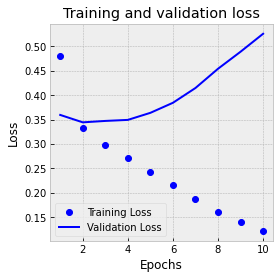

In [21]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label = "Training Loss")
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title("Training and validation loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

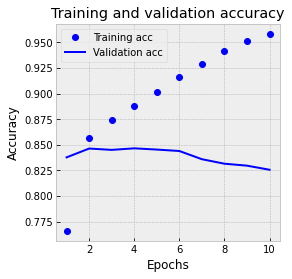

In [22]:
plt.clf() # 그림 초기화

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title("Training and validation accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## Step5 모델 훈련 ♣ Model 3 - GlobalMaxPooling

In [23]:
model3.compile(optimizer = 'adam',
             loss = 'binary_crossentropy', 
             metrics=['accuracy'])

epochs = 10    #20->10 일찍 수렴하여 줄임

history = model3.fit(partial_x_train, partial_y_train,
                   epochs = epochs, batch_size = 512,
                   validation_data = (x_val, y_val),
                   verbose = 1)

Epoch 1/10
266/266 [==============================] - 1s 4ms/step - loss: 0.6138 - accuracy: 0.7453 - val_loss: 0.4523 - val_accuracy: 0.8170
Epoch 2/10
266/266 [==============================] - 1s 4ms/step - loss: 0.3837 - accuracy: 0.8367 - val_loss: 0.3563 - val_accuracy: 0.8409
Epoch 3/10
266/266 [==============================] - 1s 4ms/step - loss: 0.3293 - accuracy: 0.8604 - val_loss: 0.3435 - val_accuracy: 0.8479
Epoch 4/10
266/266 [==============================] - 1s 4ms/step - loss: 0.3034 - accuracy: 0.8735 - val_loss: 0.3421 - val_accuracy: 0.8495
Epoch 5/10
266/266 [==============================] - 1s 4ms/step - loss: 0.2847 - accuracy: 0.8830 - val_loss: 0.3446 - val_accuracy: 0.8497
Epoch 6/10
266/266 [==============================] - 1s 4ms/step - loss: 0.2692 - accuracy: 0.8901 - val_loss: 0.3494 - val_accuracy: 0.8477
Epoch 7/10
266/266 [==============================] - 1s 4ms/step - loss: 0.2561 - accuracy: 0.8966 - val_loss: 0.3548 - val_accuracy: 0.8481
Epoch 

## Step6 Loss, Accuracy 그래프 시각화 ♣ Model 3 - GlobalMaxPooling

In [24]:
results = model3.evaluate(x_test, y_test, verbose = 2)
print(results)

1537/1537 - 2s - loss: 0.3948 - accuracy: 0.8408
[0.3948032855987549, 0.8407551050186157]


In [25]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


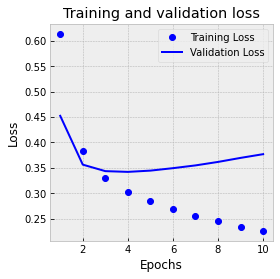

In [26]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label = "Training Loss")
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title("Training and validation loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

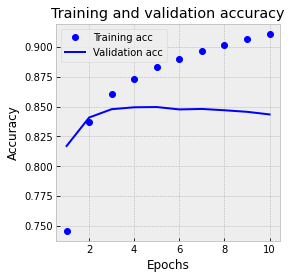

In [27]:
plt.clf() # 그림 초기화

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title("Training and validation accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## Step7 학습된 Embedding 레이어 분석¶

In [28]:
model = model1
#model = model2
#model = model3
embedding_layer = model.layers[0] # 학습한 모델의 첫 번째 레이어
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 15)


In [29]:
import os

# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [30]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['개인']
vector

array([-0.07051272, -0.10436039, -0.02439352,  0.04175408,  0.01960815,
        0.03756621, -0.0431677 ,  0.04114091, -0.03193523, -0.05905824,
        0.0463246 , -0.00482816, -0.0434989 ,  0.00963888, -0.03172582],
      dtype=float32)

In [31]:
word_vectors.similar_by_word("개인")

[('맹목', 0.8933603167533875),
 ('다시', 0.8835231065750122),
 ('투쟁', 0.8741797804832458),
 ('그걸', 0.8721303343772888),
 ('난', 0.863027036190033),
 ('지나쳤', 0.8605515956878662),
 ('페인', 0.8529510498046875),
 ('느끼', 0.8412781357765198),
 ('남한', 0.8364503979682922),
 ('바꾸', 0.8234293460845947)]

## Step8 한국어 Word2Vec 임베딩 활용하여 성능개선

In [32]:
import gensim

In [33]:
import os
#한국어 Word2Vec 모델 로드
datapath = os.getenv('HOME')+'/aiffel/ko.bin'
word2vec = gensim.models.Word2Vec.load(datapath)
print(type(word2vec))

<class 'gensim.models.word2vec.Word2Vec'>


In [34]:
#Word2Vec는 입력한 단어에 대해서 가장 유사한 단어들을 출력하는 model.wv.most_similar을 지원
#가장 유사한 단어 출력
print(word2vec.wv.most_similar("개인"))
word2vec.similar_by_word("개인")

[('개개인', 0.6724757552146912), ('사회적', 0.5781126618385315), ('프라이버시', 0.5577560663223267), ('사생활', 0.5527251362800598), ('개인적', 0.5497498512268066), ('개별', 0.5410588979721069), ('타인', 0.5309498310089111), ('고객', 0.5252301692962646), ('개별적', 0.5245020389556885), ('소비자', 0.5197153091430664)]


/home/aiffel-dj56/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  after removing the cwd from sys.path.


[('개개인', 0.6724757552146912),
 ('사회적', 0.5781126618385315),
 ('프라이버시', 0.5577560663223267),
 ('사생활', 0.5527251362800598),
 ('개인적', 0.5497498512268066),
 ('개별', 0.5410588979721069),
 ('타인', 0.5309498310089111),
 ('고객', 0.5252301692962646),
 ('개별적', 0.5245020389556885),
 ('소비자', 0.5197153091430664)]

In [35]:
#임베딩 벡터 확인
vector = word2vec['개인']
print(vector.shape) #200 word_vector_dim
vector


(200,)


/home/aiffel-dj56/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


array([-1.3488506 ,  0.4974418 ,  1.2620001 ,  0.26149538, -1.084291  ,
       -1.0342678 , -1.2460518 , -0.00457514, -0.706603  , -1.0799145 ,
        2.5139096 , -0.7577472 , -2.23177   , -2.2568793 , -0.4859126 ,
       -0.20420103,  0.343897  ,  0.5967241 , -0.3738979 , -0.76277953,
        0.48358265,  0.7864506 , -0.9538533 ,  0.40361398,  0.780665  ,
       -0.46171355, -1.5506473 , -0.8753521 , -1.5893837 , -1.088497  ,
       -1.2101454 , -2.2962773 ,  0.08834849, -0.5249705 , -0.85460824,
       -0.59696925,  1.625654  , -1.4456431 ,  2.3876922 ,  2.0943158 ,
        2.3110042 ,  0.42499924,  1.1387614 ,  0.10984266, -1.4550694 ,
       -1.1998249 ,  1.6262128 , -0.1907273 ,  1.0495535 , -0.450022  ,
        0.8003222 , -0.8544472 , -0.7657552 , -1.0366787 , -0.75405407,
       -0.6928993 ,  1.1886523 ,  0.64530057, -0.7713429 , -0.21395175,
        2.0844107 ,  0.328075  ,  0.8534163 , -0.7187584 , -0.74870545,
       -0.32887816, -0.27682212,  1.1654854 ,  0.37709785,  0.82

In [36]:
vocab_size = 10000   #사전 단어 수
word_vector_dim = 200   #임베딩 벡터 차원

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding matrix에 word2vec 워드를 단어 하나식마다 차례차례 카피한다.
for i in range(4, vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]


/home/aiffel-dj56/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  
/home/aiffel-dj56/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


In [37]:
from tensorflow.keras.initializers import Constant

# 모델 구성
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim,
                        embeddings_initializer = Constant(embedding_matrix),  #임베딩 매트릭스 추가
                        input_length = maxlen,
                        trainable = True))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.MaxPooling1D(5))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 67, 200)           2000000   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 61, 16)            22416     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 12, 16)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 6, 16)             1808      
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 16)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                

In [38]:
# 학습하기
model.compile(optimizer = 'adam',
             loss = 'binary_crossentropy',
             metrics=['accuracy'])

epochs = 10    #20->10 일찍 수렴하여 줄임

history = model.fit(partial_x_train,
                   partial_y_train,
                   epochs = epochs,
                   batch_size = 512, validation_data=(x_val, y_val),
                   verbose=1)

Epoch 1/10
266/266 [==============================] - 12s 45ms/step - loss: 0.5903 - accuracy: 0.6710 - val_loss: 0.4791 - val_accuracy: 0.7723
Epoch 2/10
266/266 [==============================] - 8s 29ms/step - loss: 0.4105 - accuracy: 0.8137 - val_loss: 0.3844 - val_accuracy: 0.8306
Epoch 3/10
266/266 [==============================] - 8s 29ms/step - loss: 0.3473 - accuracy: 0.8484 - val_loss: 0.3721 - val_accuracy: 0.8343
Epoch 4/10
266/266 [==============================] - 8s 30ms/step - loss: 0.3095 - accuracy: 0.8674 - val_loss: 0.3602 - val_accuracy: 0.8401
Epoch 5/10
266/266 [==============================] - 8s 30ms/step - loss: 0.2843 - accuracy: 0.8803 - val_loss: 0.3592 - val_accuracy: 0.8435
Epoch 6/10
266/266 [==============================] - 8s 30ms/step - loss: 0.2606 - accuracy: 0.8922 - val_loss: 0.3715 - val_accuracy: 0.8415
Epoch 7/10
266/266 [==============================] - 8s 29ms/step - loss: 0.2408 - accuracy: 0.9017 - val_loss: 0.3868 - val_accuracy: 0.837

In [39]:
# 테스트셋을 통한 모델 평가
results = model.evaluate(x_test, y_test, verbose=2)
print(results)


1537/1537 - 4s - loss: 0.4530 - accuracy: 0.8324
[0.4530408978462219, 0.8323534727096558]


In [40]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


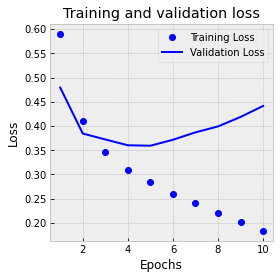

In [41]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label = "Training Loss")
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title("Training and validation loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

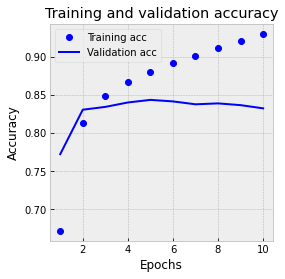

In [42]:
plt.clf() # 그림 초기화

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title("Training and validation accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## ◈ 결과 및 토의

### 모델 별 결과값 비교 

예상과 같이 3가지 모델중에는 `RNN 모델`이 훨씬 좋은 결과를 얻었다. 그러나, Word2Vec을 활용한 성능개선은 85% 이상의 결과를 얻지 못하였다.
또한, Stopwords를 어떤 것을 사용하느냐에 따라 결과가 달라지는지 시도하여 보았다. Stopwords가 많을수록 좀더 정밀한 결과값을 얻을 것이라고 예상하였으나, 오히려 기본적인 조사로만된 가장 적은 Stopwords를 사용할 때 더 좋은 결과를 얻을 수 있었다. 


### 1- Stopwords 18개

Step6 Loss, Accuracy **♣ Model 1 - LSTM(RNN)**  
1537/1537 - 2s - **`loss: 0.4884 - accuracy: 0.8476`**  ★  
[0.4883747398853302, 0.84763103723526]

Step6 Loss, Accuracy **♣ Model 2 - Conv(CNN)**  
1537/1537 - 4s - **`loss: 1.0109 - accuracy: 0.8108`**  
[1.0108782052993774, 0.8108305931091309]  

Step6 Loss, Accuracy **♣ Model 3 - GlobalMaxPooling**  
1537/1537 - 2s - **`loss: 0.4831 - accuracy: 0.8297`**  
[0.4830852448940277, 0.8297088742256165]  

Step8 한국어 **Word2Vec 임베딩 활용 성능개선**   
1537/1537 - 4s - **`loss: 0.8261 - accuracy: 0.8228`**  
[0.826065182685852, 0.8227515816688538]  

### 2- Stopwords 675개
Step6 Loss, **♣ Model 1 - LSTM(RNN)**  
1537/1537 - 2s - **`loss: 0.5203 - accuracy: 0.8360`**  
[0.5203172564506531, 0.8360355496406555]  

Step6 Loss, Accuracy **♣ Model 2 - Conv(CNN)**  
1537/1537 - 4s - **`loss: 1.0671 - accuracy: 0.7576`**  
[1.0670971870422363, 0.757593035697937]  

Step6 Loss, Accuracy **♣ Model 3 - GlobalMaxPooling**  
1537/1537 - 2s - **`loss: 0.5099 - accuracy: 0.8264`**   
[0.5099098682403564, 0.8263522982597351]

### 3- Stopwords 101개
Step6 Loss, Accuracy **♣ Model 1 - LSTM(RNN)**    
1537/1537 - 2s - **`loss: 0.4660 - accuracy: 0.8314`**   
[0.4659859240055084, 0.8313973546028137]

Step6 Loss, Accuracy **♣ Model 2 - Conv(CNN)**  
1537/1537 - 4s - **`loss: 1.0196 - accuracy: 0.7766`**    
[1.0195648670196533, 0.776552677154541]

Step6 Loss, Accuracy **♣ Model 3 - GlobalMaxPooling**  
1537/1537 - 2s - **`loss: 0.5186 - accuracy: 0.8198`**  
[0.5185568332672119, 0.8198221921920776]

Step8 한국어 **Word2Vec 임베딩 활용 성능개선**     
1537/1537 - 4s - **`loss: 0.8922 - accuracy: 0.7749`**  
[0.892214298248291, 0.7748641967773438]

 
인공지능의 한 분야인 자연어처리는 기존에 가진 텍스트터를 분류 웹 검색, 정보 검색, 순위 지정 및 문서 분류와 같은 많은 응용 프로그램에서 중요한 작업입니다. 텍스트 분류의 목표는 텍스트 문서를 스팸 탐지, 감정 분석 또는 사용자 검토 범주화와 같이 하나 이상의 정의된 범주로 자동 분류하는 것입니다.  
최근에, 이런 특성을 이용하여 사용자의 감성분석 결과를 통해 제품의 설계나 마케팅에 적극적으로 사용하고 있는 추세이다. 그러나 과거 텍스트 분류 작업은 여러 가지 이유로 발전이 더딘 편이었으나, 데이터나 신경망을 기반으로 한 모델들이 점점 대중적으로 보급되면서 기존의 한계점으로 인식되어온 정확도와 속도가 많이 개선되리라 생각한다.

`한국어에서의 토큰화의 어려움`
1) 한국어는 교착어이다.
띄어쓰기 단위가 영어처럼 독립적인 단어라면 띄어쓰기 단위로 토큰화를 하면 되겠지만 한국어는 어절이 독립적인 단어로 구성되는 것이 아니라 조사 등의 무언가가 붙어있는 경우가 많아서 이를 전부 분리해줘야 한다는 의미  
2) 한국어는 띄어쓰기가 영어보다 잘 지켜지지 않는다.

 `Word2vec모델`은 자연어 처리에서 단어를 밀집 벡터로 만들어주는 단어 임베딩 방법론이지만, 최근에 들어서는 자연어 처리를 넘어서 추천 시스템에도 사용되고 있다.

## ◈ 용어 사전 및 설명 
`워드 임베딩(word embedding) 기법`  
단어 임베딩(word embedding)이란 말뭉치(혹은 코퍼스, corpus) 내 각 단어에 일대일로 대응하는 밀집된 실수 벡터(dense vector)의 집합, 혹은 이 벡터를 구하는 행위
단어를 밀집 벡터(dense vector)의 형태로 표현하는 방법을 워드 임베딩(word embedding)이라고 합니다. 그리고 이 밀집 벡터를 워드 임베딩 과정을 통해 나온 결과라고 하여 임베딩 벡터(embedding vector)라고도 합니다.
워드 임베딩 방법론으로는 LSA, Word2Vec, FastText, Glove 등이 있습니다.

`워드투벡터(Word2Vec)`  
단어 간 유사도를 반영할 수 있도록 단어의 의미를 벡터화 할 수 있는 방법이 필요합니다. 그리고 이를 위해서 사용되는 대표적인 방법이 워드투벡터(Word2Vec)

`토큰화(Tokenization)`  
자연어 처리에서 크롤링 등으로 얻어낸 코퍼스 데이터가 필요에 맞게 전처리되지 않은 상태라면, 해당 데이터를 사용하고자하는 용도에 맞게 토큰화(tokenization) & 정제(cleaning) & 정규화(normalization)하는 일을 하게 됩니다. 이번 챕터에서는 그 중에서도 토큰화에 대해서 배우도록 합니다.

주어진 코퍼스(corpus:말뭉치)에서 토큰(token)이라 불리는 단위로 나누는 작업을 토큰화(tokenization)라고 부릅니다. 토큰의 단위가 상황에 따라 다르지만, 보통 `의미있는 단위로 토큰을 정의`합니다.


### 루브릭

**1. 다양한 방법으로 `Text Classification 태스크`를 성공적으로 구현하였다.**  
3가지 이상의 모델이 성공적으로 시도됨  


**2. `gensim을 활용`하여 자체학습된 혹은 `사전학습된 임베딩 레이어`를 분석하였다.**    
`gensim의 유사단어 찾기`를 활용하여 자체학습한 임베딩과 사전학습 임베딩을 적절히 분석함  


**3. `한국어 Word2Vec`을 활용하여 가시적인 성능 향상을 달성했다.**  
네이버 영화리뷰 데이터 `감성분석 정확도를 85%` 이상 달성함  - **`RNN 모델에서 84.76%`**